### Setup - imports, constants, download of data from GitHub

In [115]:
import os
import glob
import tensorflow as tf
import tensorflow.keras.models as tfm
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tfc
import tensorflow.keras.utils as tfu
import sklearn.model_selection as skms
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import time
import functools
import IPython.display as ipd
import pandas as pd

os.system("pip install keras-flops > /dev/null")
import keras_flops as kf

SEED = 42
SAMPLES_PER_MEASUREMENT = 119
LINES_PER_MEASUREMENT = SAMPLES_PER_MEASUREMENT + 1
NUMBER_OF_LABELS = 5
LABELS = ["Alohomora", "Arresto Momentum", "Avada Kedavra", "Locomotor", "Revelio"]

LARGE_DATA_SET = True  # set to True to train on larger data set, otherwise smaller will be used
data_set_dir = "data_large" if LARGE_DATA_SET else "data"

# create input/output directories and download data
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs(data_set_dir, exist_ok=True)

if not os.path.isfile(f"{data_set_dir}/spells.zip"):
    os.system(f"wget -P {data_set_dir}/ https://github.com/xmihol00/robust_magic_wand/raw/main/{data_set_dir}/spells.zip")
    os.system(f"unzip {data_set_dir}/spells.zip")

### Functions for data processing, creation of data sets and model analysis

In [116]:
def get_stroke_samples(data):
    angle_samples = np.zeros((SAMPLES_PER_MEASUREMENT, 3))
    stroke_samples = np.zeros((SAMPLES_PER_MEASUREMENT, 2))
    rows_of_samples = [list(map(lambda x: float(x), line.split(','))) for line in data.split('\n') if line]

    for i in range(0, len(rows_of_samples), SAMPLES_PER_MEASUREMENT): 
        measurment = np.array(rows_of_samples[i: i+SAMPLES_PER_MEASUREMENT])
        acceleration_average = np.average(measurment[:, 0:3], axis=0)

        # calcualte angle
        previous_angle = np.zeros(3)
        for j, gyro_sample in enumerate(measurment[:, 3:6]):
            angle_samples[j] = previous_angle + gyro_sample / SAMPLES_PER_MEASUREMENT
            previous_angle = angle_samples[j]     
        angle_avg = np.average(angle_samples, axis=0) # average angle

        # calculate stroke
        acceleration_magnitude = np.sqrt(acceleration_average.dot(acceleration_average.T)) # dot product insted of squaring
        acceleration_magnitude += (acceleration_magnitude < 0.0001) * 0.0001 # prevent division by 0
        normalzied_acceleration = acceleration_average / acceleration_magnitude
        normalized_angle = angle_samples - angle_avg
        stroke_samples[:, 0] = -normalzied_acceleration[1] * normalized_angle[:, 1] - normalzied_acceleration[2] * normalized_angle[:, 2]
        stroke_samples[:, 1] =  normalzied_acceleration[1] * normalized_angle[:, 2] - normalzied_acceleration[2] * normalized_angle[:, 1]
        yield stroke_samples

def laod_dataset(directory, one_hot=True, seed=SEED):
    data = ""
    labels = []
    for i, file_name in enumerate(sorted(glob.glob(f"{directory}/*.csv"))): # sort the labels alphabetically
        file = open(file_name, "r")
        file.readline() # skip header
        read_lines = file.read()
        labels += [i] * (read_lines.count("\n") // LINES_PER_MEASUREMENT)
        data += read_lines
        file.close()

    arrays = np.zeros((len(labels), 2 * SAMPLES_PER_MEASUREMENT), dtype=np.float32)

    for i, stroke_samples in enumerate(get_stroke_samples(data)): 
        stroke_samples -= np.min(stroke_samples, axis=0) # make samples in range from 0 to x
        stroke_samples /= np.max(stroke_samples, axis=0) # normalize values from 0 to 1
        arrays[i] = stroke_samples.reshape(-1)

    X_train, X_test, y_train, y_test = skms.train_test_split(arrays, labels, test_size=0.2, random_state=seed)

    if one_hot:
        # one-hot encoding of labels
        y_train = tfu.to_categorical(y_train, num_classes=5)

    return X_train, X_test, y_train, np.array(y_test)

def representative_dataset(data_set):
    for sample in data_set:
        yield [np.expand_dims(sample, 0)]

def collect_model_summary(summary_line, model_dict):
    match = re.match(r"(.*?): ([\d,]+)", summary_line)
    if match:
        match = match.groups()
        model_dict[match[0].replace("params", "parameters")] = int(match[1].replace(',', ''))

### Model definition

In [117]:
hidden_activation = tf.keras.layers.LeakyReLU(0.1)
droput_1 = 0.4
droput_2 = 0.3
droput_3 = 0.25

model = tfm.Sequential([
    tfl.Dense(units=50, activation=hidden_activation),
    tfl.Dropout(droput_2),
    tfl.Dense(units=25, activation=hidden_activation),
    tfl.Dropout(droput_3),
    tfl.Dense(units=5, activation="softmax")
])

model_name = "Final model"

### Load the data set

In [118]:
X_train, X_test, y_train, y_test = laod_dataset(data_set_dir)

### Train with validation data set to get the relevant number of epochs needed for training

In [119]:
# make results reproduceable
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

results = {}

# get weights for the given seed
model.build(X_train.shape)
weights = model.get_weights()

# get the best number of epochs based on validation data set
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=2,
                    callbacks=[tfc.EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=False)]).history
epochs = len(history["loss"]) - 3
results["Epochs"] = epochs

Epoch 1/100
10/10 - 0s - loss: 1.7142 - accuracy: 0.2906 - val_loss: 1.2978 - val_accuracy: 0.5750 - 398ms/epoch - 40ms/step
Epoch 2/100
10/10 - 0s - loss: 1.1170 - accuracy: 0.6344 - val_loss: 0.9467 - val_accuracy: 0.7750 - 77ms/epoch - 8ms/step
Epoch 3/100
10/10 - 0s - loss: 0.8440 - accuracy: 0.7750 - val_loss: 0.7260 - val_accuracy: 0.8625 - 48ms/epoch - 5ms/step
Epoch 4/100
10/10 - 0s - loss: 0.6687 - accuracy: 0.8469 - val_loss: 0.5831 - val_accuracy: 0.8750 - 32ms/epoch - 3ms/step
Epoch 5/100
10/10 - 0s - loss: 0.5431 - accuracy: 0.8375 - val_loss: 0.4848 - val_accuracy: 0.8875 - 59ms/epoch - 6ms/step
Epoch 6/100
10/10 - 0s - loss: 0.4673 - accuracy: 0.8781 - val_loss: 0.4433 - val_accuracy: 0.8875 - 37ms/epoch - 4ms/step
Epoch 7/100
10/10 - 0s - loss: 0.4057 - accuracy: 0.8906 - val_loss: 0.3889 - val_accuracy: 0.9000 - 46ms/epoch - 5ms/step
Epoch 8/100
10/10 - 0s - loss: 0.3975 - accuracy: 0.8969 - val_loss: 0.3605 - val_accuracy: 0.8875 - 34ms/epoch - 3ms/step
Epoch 9/100
10

### Train on the whole train data set

In [120]:
# reset the initialized weights
model.set_weights(weights)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
train_start = time.time()
model.fit(X_train, y_train, epochs=epochs, validation_split=0.0, batch_size=32, verbose=2)
results["Training time GPU"] = f"{(time.time() - train_start):.2f} s"

Epoch 1/7
13/13 - 0s - loss: 1.6461 - accuracy: 0.2975 - 267ms/epoch - 21ms/step
Epoch 2/7
13/13 - 0s - loss: 1.0147 - accuracy: 0.6975 - 16ms/epoch - 1ms/step
Epoch 3/7
13/13 - 0s - loss: 0.7588 - accuracy: 0.7825 - 28ms/epoch - 2ms/step
Epoch 4/7
13/13 - 0s - loss: 0.6139 - accuracy: 0.8200 - 19ms/epoch - 1ms/step
Epoch 5/7
13/13 - 0s - loss: 0.5004 - accuracy: 0.8525 - 22ms/epoch - 2ms/step
Epoch 6/7
13/13 - 0s - loss: 0.4186 - accuracy: 0.8925 - 23ms/epoch - 2ms/step
Epoch 7/7
13/13 - 0s - loss: 0.3785 - accuracy: 0.9000 - 17ms/epoch - 1ms/step


### Get the summary of the model

In [121]:
model.summary(print_fn=lambda x, y=results: collect_model_summary(x, y))
results["FLOPS"] = kf.get_flops(model, batch_size=1)

ipd.clear_output()

### Convert the model to TFLite

In [122]:
# convert the model without optimiziation (evaluation is not necessary, the results after conversion are the same)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
results_file = open(f"models/model.tflite", "wb")
results_file.write(tflite_model)
results_file.close()
results["Size"] = os.path.getsize(f"models/model.tflite")
del tflite_model

# convert the model with optimization 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = lambda x=X_train: representative_dataset(x)
tflite_model_opt = converter.convert()
results_file = open(f"models/model.tflite", "wb")
results_file.write(tflite_model_opt)
results_file.close()
results["Optimized size"] = os.path.getsize(f"models/model.tflite")
os.system(f'echo "const unsigned char model[] = {{" > models/model.h && cat models/model.tflite | xxd -i >> models/model.h && echo "}};" >> models/model.h && rm -f models/model.tflite')

ipd.clear_output()

### Predict the test data set using the full and optimized models

In [123]:
# predict and evaluate the prediction of the full model
predictions_full = model.predict(X_test, verbose=0)
predictions_full = np.argmax(predictions_full, axis=1)
results["Full model accuracy"] = f"{((predictions_full == y_test).sum() / y_test.shape[0] * 100):.2f} %"

# predict using the optimized model and evaluate the prediction
interpreter = tf.lite.Interpreter(model_content=tflite_model_opt)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
input_scale, input_zero_point = interpreter.get_output_details()[0]["quantization"]
predictions_opt = np.zeros((y_test.shape[0]))
for i, sample in enumerate(X_test):
    interpreter.set_tensor(input_index, np.expand_dims(sample / input_scale + input_zero_point, 0).astype(np.int8))
    interpreter.invoke()
    predictions_opt[i] = np.argmax(interpreter.get_tensor(output_index)[0]) # rescaling is not needed
results["Optimized model accuracy"] = f"{((predictions_opt == y_test).sum() / y_test.shape[0] * 100):.2f} %"

### Display the model statisctics

In [124]:
results

{'Epochs': 7,
 'Training time GPU': '1.05 s',
 'Total parameters': 24405,
 'Trainable parameters': 24405,
 'Non-trainable parameters': 0,
 'FLOPS': 48730,
 'Size': 99520,
 'Optimized size': 26968,
 'Full model accuracy': '86.00 %',
 'Optimized model accuracy': '88.00 %'}

### Plot the confusion matrices of the full and optimized models

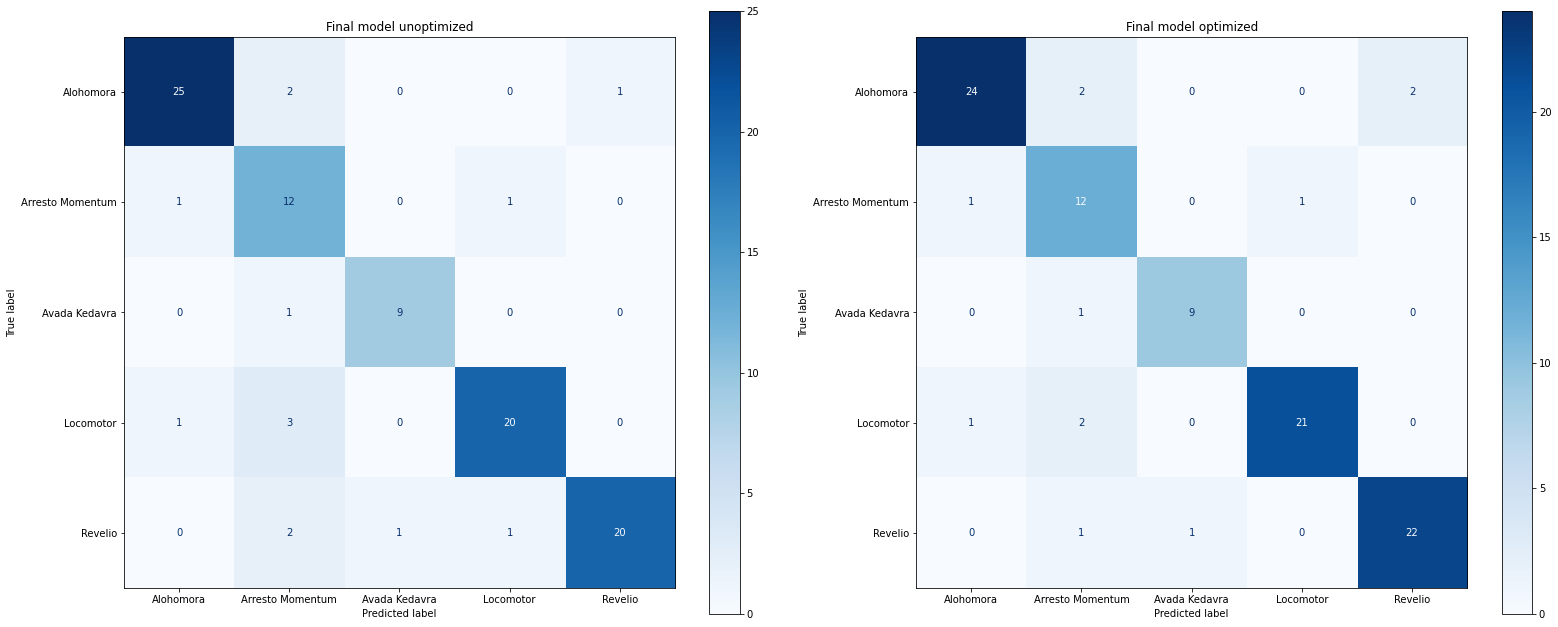

In [125]:
figure, axis = plt.subplots(1, 2) # plot of the confusion matrix for selected models
figure.set_size_inches(22, 9)
axis_idx = 0
plt.subplots_adjust(left=0.085, bottom=0.04, right=1.02, top=0.97, hspace=0.15, wspace=0.15)

# plot the full model confusion metrix
confusion_matrix = tf.math.confusion_matrix(y_test, predictions_full).numpy()
confusion_matrix = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)
axis[0].set_title(f"{model_name} unoptimized")
confusion_matrix.plot(cmap="Blues", ax=axis[0])

# plot the confusuion matrix of the optimized model
confusion_matrix = tf.math.confusion_matrix(y_test, predictions_opt).numpy()
confusion_matrix = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)
axis[1].set_title(f"{model_name} optimized")
confusion_matrix.plot(cmap="Blues", ax=axis[1])

plt.savefig("figures/final_model", dpi=300)
plt.show()

### Move the model to Arduino code

In [126]:
# do that only on a local machine, if the file exist
if os.path.isfile("final_inference/model.h"):
    os.system("cat models/model.h > final_inference/model.h")